In [15]:
%run ./PPS_Expansion_Model.ipynb

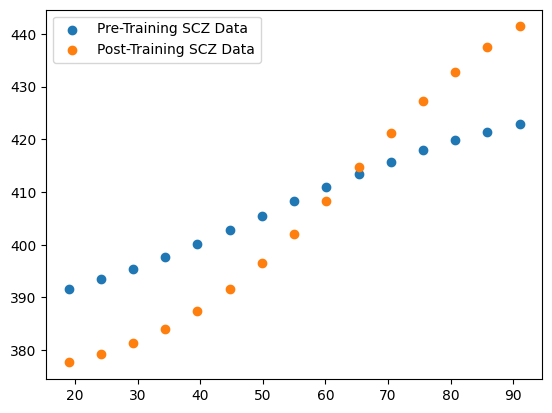

In [16]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###SCZ
ymin = 382.5
ymax = 429.5
scz_cp = 100 - 1.6415 * 30
scz_slope = 1 / 0.0450

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)

##Post-Training
###SCZ
ymin = 373.0
ymax = 455.0
scz_cp_post = 100 - 1.176 * v
scz_slope_post = 1 / 0.0615

SCZ_RTs_post = RTsig(a_distances, scz_cp_post, scz_slope_post)

plt.scatter(a_distances, SCZ_RTs, label="Pre-Training SCZ Data")
plt.scatter(a_distances, SCZ_RTs_post, label="Post-Training SCZ Data")
plt.legend()

In [3]:
from scipy.optimize import differential_evolution

Lex, Pr = 7.887e-01, 4.773e-01

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)
HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=2.603e01,
    k2=7.795e02,
    lim=2.009e01,
    alpha=9.415e-01,
)

stim_counts = 10
locav_x = 60
rho_0, siga_x, sigv_x = 6.137e-02, 6.992e01, 2.889e00


def train_sczmodel(theta):
    k = theta[0]

    SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
        n_steps=stim_counts,
        T=simtime,
        ts=ts,
        Lt=SCZLt,
        La=SCZLa,
        Lv=SCZLv,
        Wt=HCWt,
        Wa=HCWa,
        Wv=HCWv,
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=Pr,
        rho_0=rho_0,
        Wmax_a=6.5,
        Wmax_v=6.5,
        k_a=k,
        k_v=k,
        theta=0.05,
        locav_x=locav_x,
        siga_x=siga_x,
        sigv_x=sigv_x,
    )

    _, _, _, _, SCZrtpost = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=SCZLt,
        La=SCZLa,
        Lv=SCZLv,
        Wt=HCWt,
        Wa=SCZWa_tr[:, :, -1, -1],
        Wv=SCZWv_tr[:, :, -1, -1],
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=0,
        CMpr=0,
    )

    SCZ_Model_RTs_post = fit_RT(xf=SCZrtpost, yf=SCZ_RTs_post)
    cost = np.sum(
        np.square(np.divide(SCZ_RTs_post - (SCZ_Model_RTs_post), SCZ_RTs_post))
    )

    return cost * 100000


bounds = [(0, 0.1)]
train_sczmodel_res = differential_evolution(
    train_sczmodel, bounds, disp=True, workers=30, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 56.65026651280987
differential_evolution step 2: f(x)= 45.219374899939375
differential_evolution step 3: f(x)= 17.16449411259676
differential_evolution step 4: f(x)= 17.16449411259676
differential_evolution step 5: f(x)= 17.16449411259676
differential_evolution step 6: f(x)= 17.16449411259676
differential_evolution step 7: f(x)= 17.16449411259676
differential_evolution step 8: f(x)= 17.16449411259676
differential_evolution step 9: f(x)= 17.16449411259676
differential_evolution step 10: f(x)= 17.16449411259676
differential_evolution step 11: f(x)= 17.16449411259676
differential_evolution step 12: f(x)= 17.16449411259676
differential_evolution step 13: f(x)= 17.16449411259676
differential_evolution step 14: f(x)= 17.16449411259676


In [5]:
print(train_sczmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 17.16449411259676
                   x: [ 1.247e-03]
                 nit: 14
                nfev: 225
          population: [[ 1.247e-03]
                       [ 1.235e-03]
                       ...
                       [ 1.165e-03]
                       [ 1.255e-03]]
 population_energies: [ 1.716e+01  1.716e+01 ...  1.716e+01  1.716e+01]


In [6]:
## Fitted model
Lex, Pr = 7.887e-01, 4.773e-01
k_a = 1.247e-03
k_v = 1.247e-03
stim_counts = 10
locav_x = 60
rho_0, siga_x, sigv_x = 6.137e-02, 6.992e01, 2.889e00

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)
HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=2.603e01,
    k2=7.795e02,
    lim=2.009e01,
    alpha=9.415e-01,
)

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

In [7]:
_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=SCZWa_tr[:, :, -1, -1],
    Wv=SCZWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_RTs_model_post_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

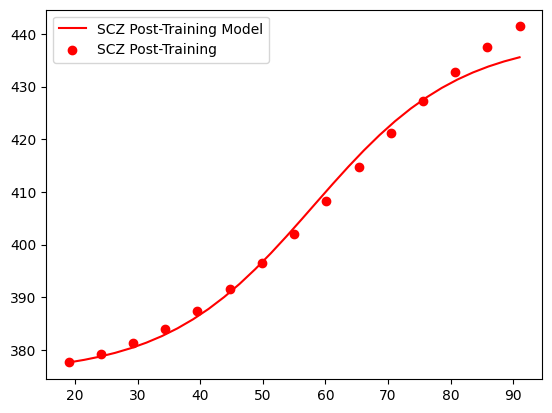

In [8]:
ymin, ymax = np.min(SCZ_RTs_model_post_scaled), np.max(SCZ_RTs_model_post_scaled)
dc, h = fitting(a_distances, SCZ_RTs_model_post_scaled)
mydistances_exp = np.linspace(a_distances[0], a_distances[-1], 30)
yf_exp = RTsig(mydistances_exp, dc, h)

plt.figure(1)
plt.plot(mydistances_exp, yf_exp, label="SCZ Post-Training Model", color="r")
plt.scatter(a_distances, SCZ_RTs_post, label="SCZ Post-Training", color="r")
plt.legend()

In [9]:
scz_error = calculate_adj_rmse(SCZ_RTs_model_post_scaled, SCZ_RTs_post, 5)
print(scz_error)

1.6702169955534683


Text(0.5, 1.0, 'Increased forgetting rate model')

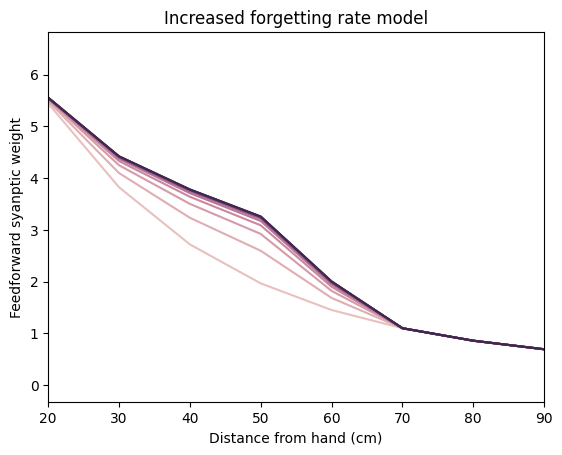

In [10]:
import seaborn as sns

tr_data = np.column_stack((SCZWa_tr[:, 1, :, 0], SCZWa_tr[:, 1, -1, -1]))

sns.lineplot(tr_data, palette="ch:dark=.20,light=.80", dashes=False, legend=False)
plt.xlim(2, 9)
plt.xticks(ticks=[2, 3, 4, 5, 6, 7, 8, 9], labels=[20, 30, 40, 50, 60, 70, 80, 90])
plt.xlabel("Distance from hand (cm)")
plt.ylabel("Feedforward syanptic weight")
plt.title("Increased forgetting rate model")

In [11]:
_, _, _, _, SCZ_Model_RTs_pre = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

In [12]:
SCZ_RTs_model_pre_scaled = fit_RT(SCZ_Model_RTs_pre, SCZ_RTs_post)
SCZ_Model_RTs_post_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

ymin, ymax = np.min(SCZ_RTs_model_pre_scaled), np.max(SCZ_RTs_model_pre_scaled)
SCZ_Pr_CP_model_pre, SCZ_Pr_SLOPE_model_pre = fitting(
    a_distances, SCZ_RTs_model_pre_scaled
)

ymin, ymax = np.min(SCZ_Model_RTs_post_scaled), np.max(SCZ_Model_RTs_post_scaled)
SCZ_Pr_CP_model_post, SCZ_Pr_SLOPE_model_post = fitting(
    a_distances, SCZ_Model_RTs_post_scaled
)

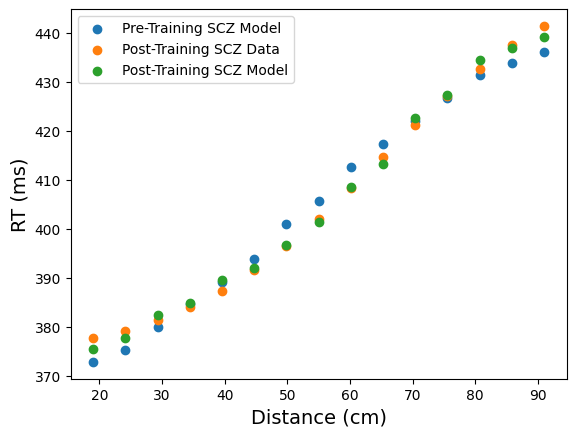

In [13]:
plt.scatter(a_distances, SCZ_RTs_model_pre_scaled, label="Pre-Training SCZ Model")
plt.scatter(a_distances, SCZ_RTs_post, label="Post-Training SCZ Data")
plt.scatter(a_distances, SCZ_Model_RTs_post_scaled, label="Post-Training SCZ Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()

In [14]:
print("Delta CP:", SCZ_Pr_CP_model_post - SCZ_Pr_CP_model_pre)
print("Delta Slope:", 1 / SCZ_Pr_SLOPE_model_post - 1 / SCZ_Pr_SLOPE_model_pre)

Delta CP: 4.446548033743717
Delta Slope: 0.000988403503086474
